# Preprocess Seismic Data

In this notebook, we pre-process the seismic data downloaded in the previous section `1_download_data.ipynb`. This step is essential for the successful application of the detection and location workflow.

In [14]:
import BPMF
import glob
import numpy as np
import os

import obspy as obs

from datetime import timedelta
from tqdm import tqdm

In [15]:
DATE = obs.UTCDateTime("2012-07-26")
dirpath_data = os.path.join(BPMF.cfg.INPUT_PATH, str(DATE.year), DATE.strftime("%Y%m%d"))

## Build the data reader

`BPMF` allows any data formats to be used. The price for flexibility is to define a function that reads the data and returns `obspy.Stream`.

In [16]:
def data_reader_mseed(
    where,
    network="*",
    station="*",
    channel="*",
    location="*",
    starttime=None,
    endtime=None,
    attach_response=False,
    data_folder="",
    **kwargs
):
    """Data reader for BPMF.

    This data reader is specifically designed for the folder tree convention
    that we use in the tutorial. We will use the same data reader at later
    stages of the workflow.

    Parameters
    -----------
    where: string
        Path to data file or root data folder.
    network: string or list, optional
        Code(s) of the target network(s).
    station: string or list, optional
        Code(s) of the target station(s).
    channel: string or list, optional
        Code(s) of the target channel(s).
    location: string or list, optional
        Code(s) of the target location(s).
    starttime: string or obspy.UTCDateTime, optional
        Target start time.
    endtime: string or obspy.UTCDateTime, optional
        Target end time.
    attach_response: boolean, optional
        If True, find the instrument response from the xml files
        and attach it to the obspy.Stream output instance.
    data_folder: string, optional
        If given, is the child folder in `where` containing
        the mseed files to read.

    Returns
    -------
    traces: obspy.Stream
        The seismic data.
    """
    from obspy import Stream

    traces = Stream()
    # read your data into traces
    data_files = glob.glob(
        os.path.join(where, data_folder, f"{network}.{station}.{location}.{channel}*")
    )
    for fname in data_files:
        traces += obs.read(fname, starttime=starttime, endtime=endtime, **kwargs)
    if attach_response:
        resp_files = glob.glob(
            os.path.join(where, "resp", f"{network}.{station}.xml")
        )
        invs = list(map(obs.read_inventory, resp_files))
        traces.attach_response(invs)
    return traces


In general, you do want to make sure you personalize this data reader for your own folder architecture. If you choose to use a similar file architecture as in this tutorial, you may want to use a more complex version of this data reader, available at `BPMF.data_reader_examples.data_reader_mseed`.

## Read the raw data

In [17]:
raw_traces = data_reader_mseed(dirpath_data, attach_response=True, data_folder="raw")

In [18]:
print(raw_traces.__str__(extended=True))

print(raw_traces[0].stats.response)

24 Trace(s) in Stream:
YH.DE08..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DE07..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DE08..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DD06..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC07..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.SAUV..HHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 100.0 Hz, 8740001 samples
YH.DC07..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.SAUV..HHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 100.0 Hz, 8740001 samples
YH.DC08..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.SPNC..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 

## Preprocess the data

First, we call `obspy.Stream.merge()` to group the different segments of a same channel within a single trace.

In [19]:
raw_traces.merge()

24 Trace(s) in Stream:

YH.DC06..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
...
(22 other traces)
...
YH.SPNC..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [20]:
# there is now a single trace per channel
print(raw_traces.__str__(extended=True))

24 Trace(s) in Stream:
YH.DC06..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC06..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC06..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC07..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC07..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC07..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC08..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC08..BHN | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DC08..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
YH.DD06..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50

Then, we use `BPMF.utils.preprocess_stream` with the below-defined parameters (some parameters were already defined when initializing the project). We do not correct for the full instrument response, as the response is mostly flat in the frequency band of interest. However, we do correct for the instrument sensitivity so that the waveform amplitudes are in physical units [m/s].

In [21]:
# preprocessing parameters
freqmin = BPMF.cfg.MIN_FREQ_HZ
freqmax = BPMF.cfg.MAX_FREQ_HZ
target_SR = BPMF.cfg.SAMPLING_RATE_HZ
target_starttime = DATE
target_endtime = DATE + timedelta(days=1.)
remove_response = False
remove_sensitivity = True

In [22]:
preprocessed_traces = BPMF.utils.preprocess_stream(
    raw_traces,
    freqmin=freqmin,
    freqmax=freqmax,
    target_SR=target_SR,
    target_starttime=target_starttime,
    target_endtime=target_endtime,
    remove_response=remove_response,
    remove_sensitivity=remove_sensitivity,
    antialiasing_filter_order=8, # make it sharp
)

In [23]:
print(preprocessed_traces.__str__(extended=True))

24 Trace(s) in Stream:
YH.DC06..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC06..BHN | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC06..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC07..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC07..BHN | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC07..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC08..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC08..BHN | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DC08..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25.0 Hz, 2160000 samples
YH.DD06..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-26T23:59:59.960000Z | 25

## Plot the preprocessed traces

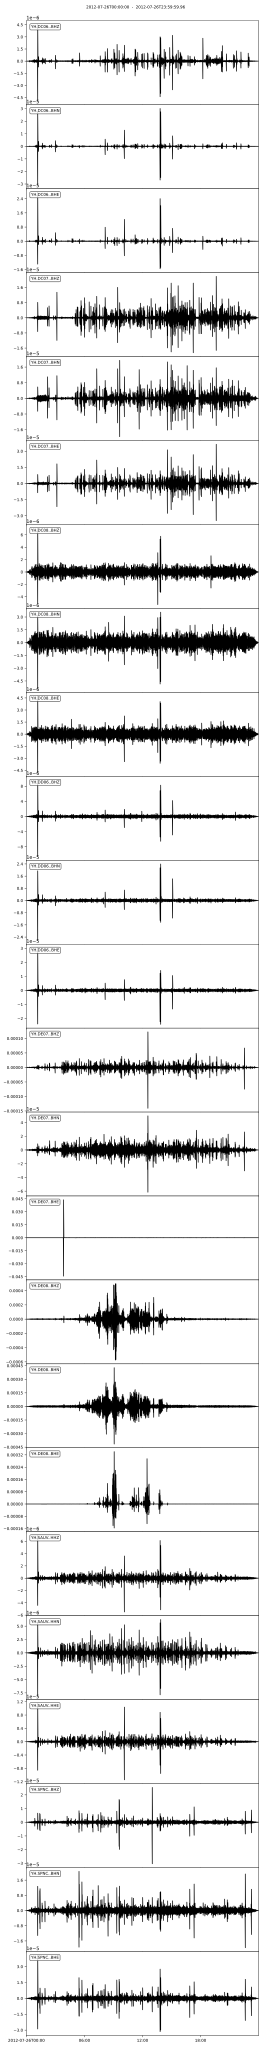

In [24]:
%config InlineBackend.figure_formats = ["svg"]

fig = preprocessed_traces.plot(equal_scale=False)

## Write the preprocessed data

Save the preprocessed data to the data base.

In [25]:
preproc_folder_name = f"preprocessed_{BPMF.cfg.MIN_FREQ_HZ:.0f}_{BPMF.cfg.MAX_FREQ_HZ:.0f}"
print("The preprocessed data will be stored at:", os.path.join(dirpath_data, preproc_folder_name))
if not os.path.isdir(os.path.join(dirpath_data, preproc_folder_name)):
    os.makedirs(os.path.join(dirpath_data, preproc_folder_name))

The preprocessed data will be stored at: ../BPMF_data/2012/20120726/preprocessed_2_12


In [26]:
for tr in tqdm(preprocessed_traces, desc="Writing preprocessed data"):
    tr.write(os.path.join(dirpath_data, preproc_folder_name, f"{tr.id}_{DATE.strftime('%Y%m%d')}.mseed"), encoding="FLOAT64", format="mseed")
# tip: it is most likely that you don't need the float64 precision. Try converting all tr.data to float32 and use encoding="FLOAT32", you will
# reduce the memory footprint of your preprocessed data set by 2!

Writing preprocessed data: 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]
